# Optimizing CLIP-IQA with NSGA II
Notebook Version: 0.32 (07/03/2024)
* better visualization of evolution with radar charts

## Project Setup

In [1]:
from evolutionary.plotting import plot_fitness_statistics
import evolutionary_imaging.processing as ip
from diffusers.utils import logging
from evolutionary_imaging.processing import create_animation_from_generations, create_generation_radar_chart_grid, save_images_from_generation
import torch
import os

/Users/msalv/dev/evolutionary-diffusion/venv/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
logging.disable_progress_bar() # Or else your output will be full of progress bars
logging.set_verbosity_error() # Enable again if you are having problems
os.environ["TOKENIZERS_PARALLELISM"] = "false" # To remove warning of libraries using tokenizers
# Change the results folder for images if you want to 
# ip.RESULTS_FOLDER = 'choose_your_destination'

def save_images_post_sort(g, a):
    save_images_from_generation(a.fronts[0], g)  # Only save from first front
    
# Check torch random state, used across all libraries. Caution setting fixed seeds as it affects not only generation but also variation.
print(torch.random.get_rng_state())

tensor([96, 88, 92,  ...,  0,  0,  0], dtype=torch.uint8)


In [3]:
from evolutionary_prompt_embedding.argument_types import PooledPromptEmbedData
from evolutionary_prompt_embedding.image_creation import SDXLPromptEmbeddingImageCreator
from evolutionary_prompt_embedding.variation import PooledArithmeticCrossover, PooledUniformGaussianMutator, UniformGaussianMutatorArguments
from evolutionary.evolutionary_selectors import TournamentSelector
from evolutionary.algorithms.nsga_ii import NSGA_II
from evolutionary_imaging.evaluators import AestheticsImageEvaluator, CLIPScoreEvaluator, MultiCLIPIQAEvaluator, \
    SingleCLIPIQAEvaluator
from evolutionary.evolution_base import MultiObjectiveEvaluator
from evolutionary_prompt_embedding.value_ranges import SDXLTurboEmbeddingRange, SDXLTurboPooledEmbeddingRange

population_size = 100
num_generations = 200
batch_size = 1
elitism = 1
metrics = ("quality", "brightness", "colorfullness", "complexity", "natural", "happy", "new", "real", "beautiful")

embedding_range = SDXLTurboEmbeddingRange()
pooled_embedding_range = SDXLTurboPooledEmbeddingRange()
creator = SDXLPromptEmbeddingImageCreator(batch_size=batch_size, inference_steps=3)
evaluator = MultiCLIPIQAEvaluator(metrics=metrics)
crossover = PooledArithmeticCrossover(crossover_rate=0.5, crossover_rate_pooled=0.5)
mutation_arguments = UniformGaussianMutatorArguments(mutation_rate=0.1, mutation_strength=2, 
                                                     clamp_range=(embedding_range.minimum, embedding_range.maximum)) 
mutation_arguments_pooled = UniformGaussianMutatorArguments(mutation_rate=0.1, mutation_strength=0.4, 
                                                            clamp_range=(pooled_embedding_range.minimum, pooled_embedding_range.maximum))
mutator = PooledUniformGaussianMutator(mutation_arguments, mutation_arguments_pooled)
selector = TournamentSelector(tournament_size=3)

# Prepare initial arguments
init_args = [PooledPromptEmbedData(embedding_range.random_tensor_in_range(), pooled_embedding_range.random_tensor_in_range()) 
             for _ in range(population_size)] # random start

nsga = NSGA_II(
    num_generations=num_generations,
    population_size=population_size,
    solution_creator=creator,
    selector=selector,
    crossover=crossover,
    mutator=mutator,
    evaluator=evaluator,
    elitism_count=elitism,
    initial_arguments=init_args,
    post_non_dominated_sort_callback=save_images_post_sort
)

/Users/msalv/dev/evolutionary-diffusion/venv/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Loaded StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.26.3",
  "_name_or_path": "stabilityai/sdxl-turbo",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}


In [5]:
best_solution = nsga.run()

100%|██████████| 200/200 [6:59:58<00:00, 125.99s/generation]  


[0.9962375164031982, 0.9966104626655579, 0.9862209558486938, 0.9709573984146118, 0.07007953524589539, 0.833625316619873, 0.8192796111106873, 0.996439516544342, 0.9485073089599609]


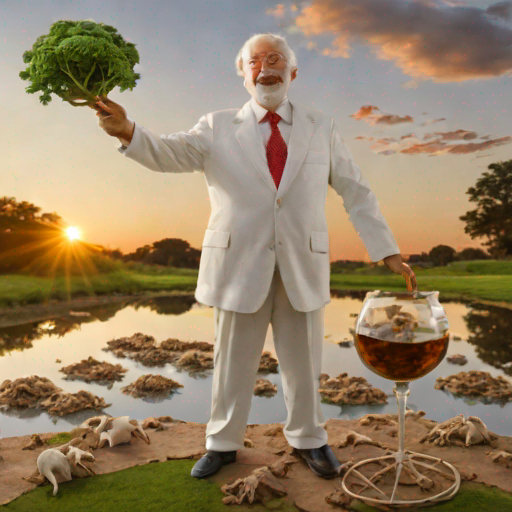

In [6]:
from diffusers.utils import make_image_grid

# Show best solution
print(best_solution.fitness)
make_image_grid(best_solution.result.images, 1, batch_size)

## Plot fitness statistics (Separately)

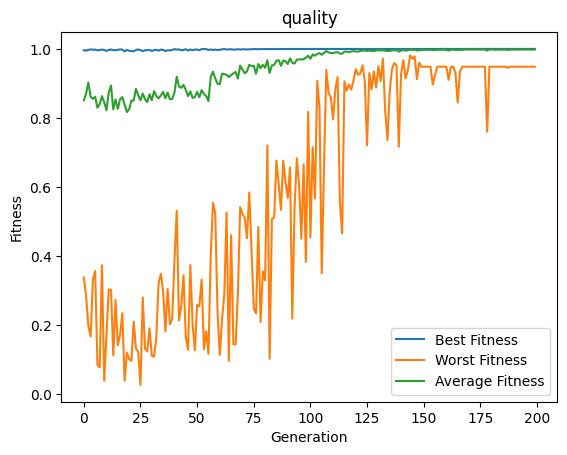

In [124]:
plot_fitness_statistics(num_generations, nsga.best_fitness, nsga.worst_fitness, nsga.avg_fitness, title=metrics[0], multi_objective_plot_index=8)

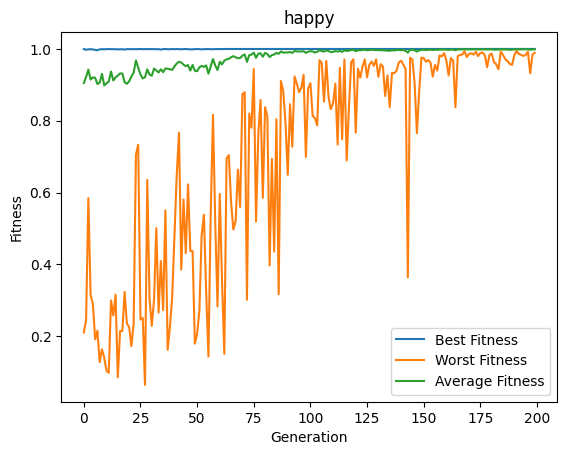

In [125]:
plot_fitness_statistics(num_generations, nsga.best_fitness, nsga.worst_fitness, nsga.avg_fitness, title=metrics[5], multi_objective_plot_index=1)

## Plot fitness statistics (Together)

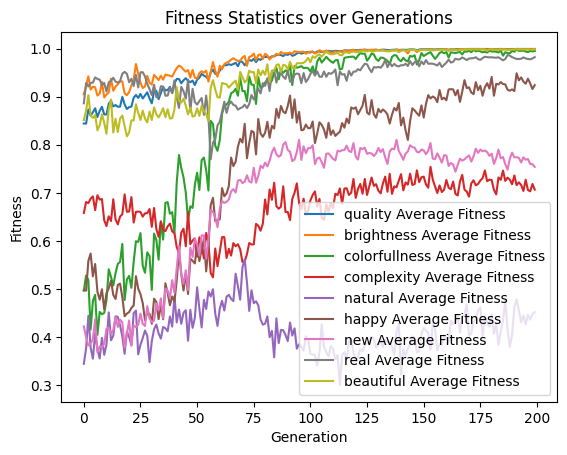

In [6]:
plot_fitness_statistics(num_generations, avg_fitness=nsga.avg_fitness, labels=metrics)